# Chapter 8 - Simulation, Scenarios and Stress Testing #
&copy; 2022 Kenneth Winston

In the previous chapter we saw a variety of distributions that can be used for situations that fall into Knight's [_a priori risk_](#frank_knight) category. If we are confident that a known distribution describes all the outcomes and all the associated probabilities for a set of variables, then we might even be able to get a closed-form description of relevant risk metrics for these variables.

But even if that situation obtains, our work isn't done. For financial applications, we'll probably want to know the rate of return of a portfolio. The portfolio could be a mutual fund, hedge fund, or institutional portfolio managed by an asset manager; it could be the positions on a trading desk; or it could be aggregate holdings of a sovereign wealth, pension, or endowment fund belonging to an asset owner.

The behavior of a portfolio of securities will be determined by a set of $k$ factors describing the financial and economic state of the world. These factors might come from a factor model like \eqref{eq:factor_practice}; they might be [key rates](#rolldown_key_rates); or they might just be individual securities. Whatever the inputs are, the sample space of interest will consist of $k$-vectors $\text{sv}$ ("state variable(s)") giving possible future states of the world. Often the convention is that such a state-of-the-world vector is expressed as a change from the current state.

Once we have the relevant state-of-the-world variables, we will also need deterministic pricing functions $R_i(\text{sv})$ that give the rate of return of the $i^{th}$ security in a portfolio one period forward, conditional on state-of-the-world $\text{sv}$ being realized. Another function is then applied to the individual pricing functions to form a desired statistic at the portfolio level; for example $\text{Port}(R_1(\text{sv}),\dots,R_n(\text{sv}))=\ln\bigl(1+\sum w_i R_i(\text{sv})\bigr)$ would give the portfolio's log-returns where $w$ is the portfolio weight vector.

For example, there are four parameters ($\beta_0$, $\beta_1$, $\beta_2$, and $\tau$) that describe a Nelson-Siegel curve in \eqref{eq:nelson_siegel}. If we are interested in modeling possible returns on a portfolio of bonds, then we might think that the relevant state-of-the-world sample space consists of 4-vectors giving the possible future values of the four Nelson-Siegel parameters. We might even think we have a state of Knightian Risk with respect to the Nelson-Siegel parameters: we have a good description of their probability distribution. But to value a portfolio of bonds being discounted by such a curve, we'll need to pass the four parameters through the formula \eqref{eq:nelson_siegel}, and then apply the pricing equation \eqref{eq:generic_pricing_equation} in order to get a pricing function $R_i(\text{sv})$ for an individual bond. The portfolio return's response to changes in the four Nelson-Siegel parameters will therefore be highly nonlinear.

**`Simulation`** is used in cases where the responses to the state-of-the-world variables are complex. A process is developed to describe the sample space: this can be a closed-form approach, or a random-number generator producing a large number of samples of the state-of-the-world vector. Then, conditional on the future evolving according to the sample draw, the object of interest &mdash; such as a portfolio of bonds discounted by the Nelson-Siegel curve based on the sample parameters &mdash; is valued. The distribution of portfolio results is then analyzed for relevant statistics.

We've already described the basic inputs for simulation. They're collected in Table 8.1:

| &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Table 8.1: Simulation Functions and Datasets |   &nbsp;              |
|:----------|:-------------:|:------------------------:|
|  Item  | Description |   Type                 |
| $\text{sv}$    | Environmental (state-of-the-world) variables  | k-vector |
| $R_i(\text{sv})$    |  Pricing (rate-of-return) function for $i^{th}$ security | Function |
| $\text{Port}(R_1(\text{sv}),\dots,R_n(\text{sv}))$   |  Composition function forming portfolio-level<br> datum (return/log-return/price) | Function |

We have seen this technique already. The short rate models in Sections 3.8.2 through 3.8.4 are examples of simulations; they generate a distribution of yield curves that can be used to value fixed income instruments. The resampled efficient frontier in Section 4.2.2 is another example. An efficient portfolio is a highly nonlinear function of inputs such as a mean vector, a covariance matrix, and constraints. The resampling process is designed to produce an informative distribution of portfolios from which either a range or a center can be chosen.

We can consider these techniques _guided looks into the future_. If the technique is good, then the future that actually does unfold (and futures reasonably like the true one) will be among the outcomes, and their associated probabilities will cause us to plan appropriately.
<font color="white">$$\label{eq:factor_practice}\tag{5.40}$$
$$\label{eq:generic_pricing_equation}\tag{3.2}$$
$$\label{eq:nelson_siegel}\tag{3.14}$$
$$\label{eq:normal_var}\tag{2.8}$$
$$\label{eq:normal_cvar}\tag{2.9}$$
$$\label{eq:three_currency_sampcov}\tag{4.20}$$
</font> 

## 8.1 Historical Simulation

Perhaps the simplest way to generate outcomes and probabilities is **`historical simulation`**. In its purest form, this method requires no model other than the empirical history of the securities in our portfolio. The sample space is simply what happened in the past, and the associated probabilities can be totally agnostic &mdash; each historical observation has the same weight &mdash; or weighted according to a model such as: more recent observations are more important than older observations.

As we noted in Chapter 4, the most naive forms of historical simulation &mdash; where an analyst simply expects the past to repeat itself &mdash; can be misleading guides to the future. Good judgment is required to find the frontier between the advantages of being model-free and the prediction failures of being too literal.

One commonly used version of historical simulation attempts to get the best of both worlds by using factor models for securities. As we saw in Chapter 6, not only do factor models help give better predictions of future behavior; they also help with missing data. For example, a portfolio may contain Snap (SNAP), the company behind the Snapchat application. Snap common stock started trading in 2017, so an analyst in the year 2022 may determine that there isn't enough SNAP history to infer patterns reliably. But SNAP might be modeled as some combination of factors like technology and growth; these factors have long histories and more reliable relationships than do individual securities.

We'll analyze a historical simulation involving the Swissie, pound, yen example from Section 4.1.2, using data going back to 1971. The sample space will simply be all $T$ 3-vectors of (CHF,GBP,JPY) log-returns that were observed in the past, and individual pricing functions will be $R_i(sv)=\exp(sv_i)-1$, where $sv$ is one of the 3-vectors in the sample space.

Suppose that the portfolio of interest is an equal-weighted portfolio of the three currencies, $w=(1/3, 1/3, 1/3)^{\intercal}$. Let $X$ be the $T\times3$ matrix whose $(t,i)$ entry is the {(dollars per currency i on day t) divided by (dollars per currency i on day t-1)} minus one. $X$ is the priced sample space. The $T$-vector of log-returns at the portfolio level would be $\text{Port}(X)=\ln\bigl(1+Xw\bigr)$.

The $i^{th}$ observation of the $T$ observations in $\text{Port}(X)$ is assumed to have a probability $p_t$ of being observed. In this context the time index runs backward so $\text{Port}(X_1)$ is the most recent observation and $\text{Port}(X_T)$ is the oldest observation. In the agnostic version where there is no information to prioritize observations, $p_t=\frac{1}{T}\enspace\forall t$.

It would be reasonable to assume that going forward, the world will look more like it did last year than it did in 1971. In that case observation distribution $p_t$ (where $p_i\geq p_j$ when $i\leq j$) would be appropriate. A common technique is an **`exponentially weighted moving average`**, or **`EWMA`**: the observation probabilities are given by
$$p_t=\frac{2^{-h(t-1)}}{\sum_{s=0}^{T-1}2^{-hs}}=\frac{2^{-h(t-1)}(1-2^{-h})}{1-2^{-hT}}\approx2^{-h(t-1)}(1-2^{-h})\approx2^{-h(t-1)}\frac{h\cdot ln(2)}{1+\frac{h\cdot ln(2)}{2}}\label{eq:ewma_def}\tag{8.1}$$

$h=1/252$ in \eqref{eq:ewma_def} would be a one year half-life if the observation periodicity was business-daily, since there are about 252 business days in a year. In that case the observations from a year ago would be half as probable as the most recent observation; three years ago would be one eighth as probable.

More generally, the idea of **`importance ranking`** resonates intuitively: distinguishing which past data is more or less relevant to the future is a sensible approach. In EWMA, a simple distance metric (time) was used for ranking. Other kinds of importance ranking look at richer feature sets describing time periods. For example, a set of economic features including a stock market earnings/price ratio, interest rates, GDP changes, and unemployment rates might be used to describe conditions at each time period. Then a distance metric between current features and past features can be used to rank or filter other past period data for use in a predictive model. 

[Czasonis, Kritzman and Turkington 2021](https://dx.doi.org/10.2139/ssrn.3803440) define "relevance" as a Mahalanobis distance between past features and present features, and use this relevance metric to filter out past data whose features are far from current features. The Mahalanobis distance is $(f_0-f_t)^{\intercal}C^{-1}(f_0-f_t)$, where $f_0$ ($f_t$) is the current (past) feature vector, and $C$ is the feature covariance matrix. Since the covariance matrix may have poor condition, inverting it might have a stability problem. A metric that avoids inverting the matrix is $\frac{1-\rho}{1+\rho}$ where $\rho$ is the correlation between feature vectors: this can be used to downgrade or eliminate low- or negative-correlation past periods.

Returning to the simple equally-weighted (in time) data, a histogram of the outcomes for the 3-currency portfolio (equally weighted by currency) is shown below. The pattern looks familiar:

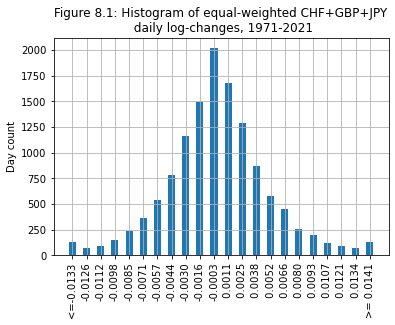

╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.041114  │
├────────────────────┼───────────────┤
│ Max                │     0.0516067 │
├────────────────────┼───────────────┤
│ Mean               │     7.5e-05   │
├────────────────────┼───────────────┤
│ Median             │     1.73e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0051541 │
├────────────────────┼───────────────┤
│ Skewness           │     0.241948  │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     4.79666   │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 12380.3       │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0255342 │
├────────────────────┼───────────────┤
│ 99% VaR            │   

In [1]:
%matplotlib inline
import pandas as pd
import qrpm_funcs as qf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.stats as spst
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#Show histogram of equal-weighted
#CHF-GBP-JPY log-changes
w=np.array([1/3]*3).T
#apply transform to get returns at portfolio level
portfolio=np.log(1+np.dot(np.exp(difflgs)-1,w))

#portfolio now contains the equal-weighted portfolio's
#log-returns. Create buckets - hist function doesn't
#seem to have "x or less" or "x or more" buckets
bucketnames=[]
bucketcounts=[]
#Bucket the end percentiles
low1=np.percentile(portfolio,1)
high1=np.percentile(portfolio,99)
bucketnames.append('<=%7.4f' % low1)
bucketcounts.append(sum(1 for x in portfolio if low1 >= x))
#Count 20 even buckets in between low and high
nbucket=20
bucketwidth=(high1-low1)/nbucket
for i in range(20):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(sum(1 for x in portfolio if (x>=attach and x<=detach)))

#last bucket
bucketnames.append('>=%7.4f' % high1)
bucketcounts.append(sum(1 for x in portfolio if x >= high1))

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 8.1: Histogram of equal-weighted CHF+GBP+JPY\n daily log-changes, '+ \
          lgdates[0][:4]+'-'+lastday[:4])
plt.show();
    
statnames,metrics,table=qf.StatsTable(np.exp(portfolio)-1)
headers=['Statistic','Value']
print(tabulate(table, headers, tablefmt='fancy_grid'))

port_log_ret=0
for t in range(len(d)):
    port_log_ret+=np.log(np.mean(np.exp(d[t,:])))
print('Portfolio cumulative return:',np.exp(port_log_ret)-1)
print('Portfolio annual return:',np.exp(port_log_ret/int(len(d)/252))-1)

The statistics table is based on daily portfolio returns. So a very simple look into the future of an equally weighted portfolio of Swissies, pounds and yen tells us that IF we expect the future to be like the historical record since 1971, we will be drawing log-returns from the distribution shown in Figure 8.1 that looks normal at first glance, but is actually fat-tailed.

As it turns out the daily-rebalanced equal-weighted portfolio would have made a profit &mdash; more than doubling since 1971. If an analyst has no model of expected returns and is just looking to estimate higher (second and above) moments, then quite often the historical mean is ignored or set to zero.

This example's mean is typical of short-term financial data in that it is negligible compared to the volatility. Over longer periods such as a year, the mean may not be negligible. That's because when there isn't too much serial correlation, the mean scales linearly with time, while standard deviation scales as the square root of time.

## 8.2 Delta-Normal

A second common method for generating future distributions is **`delta-normal`**. This method assumes that input variables &mdash; rates of return[$^1$](#eight_footnotes) of the three currencies in our example &mdash; will follow a multivariate normal distribution. Often the mean of the multivariate normal is assumed to be zero; as noted above, for short periodicities the mean is usually negligible compared to the higher moments.

The delta-normal method starts by mapping portfolio holdings into the appropriate exposure vector $w$. As with the historical example, this vector may simply be a vector of weights of the securities in the portfolio, with an associated covariance matrix $C$. A \eqref{eq:factor_practice}-type model $C=BFB^{\intercal}+D$ is often assumed.

For large institutional portfolios, the security-specific variance matrix $D$ in \eqref{eq:factor_practice} might be ignored. This is because only the squares of security weights appear in the quadratic form $w^{\intercal}Dw$. In a large portfolio, it is unlikely that any one security occupies more than a few percent. Squaring a few percent gets down to basis points. Further, if the factor model is well-specified, the entries of $D$ are small. This is basically the argument that was made in the development of the [Arbitrage Pricing Theory](#arbitrage_pricing) in Chapter 6.

Thus a vector of security weights $w$ can be mapped into factor loadings $b=B^{\intercal}w$, where $B$ is the factor loading matrix in \eqref{eq:factor_practice}. In that case the associated covariance matrix is the $F$ in \eqref{eq:factor_practice}.

Generally if $x$ is an asset and $f$ is a factor that might affect $x$, $\delta_f(x)=\frac{\partial x}{\partial f}$. That is, the Greek letter $\delta$ (delta) is generally used to denote the first-order sensitivity of an asset to a factor. In the delta-normal method, the deltas of more complex securities like options are added in to the exposure vector.

Thus in the delta-normal method, the appropriate statistics can be formed directly without simulation. Say $e$ is the exposure n-vector (either a security weight vector $w$ or a factor exposure vector $b$), and $M$ is the associated covariance matrix. Then the variance of the distribution of portfolio outcomes is $e^{\intercal}Me$ and the standard deviation is $\sigma=\sqrt{e^{\intercal}Me}$.

The Value at Risk at probability $p$ is $v=-(\mu+\sigma*Norm^{-1}(1-p))$ as in \eqref{eq:normal_var}. At $p=99%$, that's $2.326\sigma$. The cVaR (= Expected Shortfall since Norm is continuous) (expressed as a loss amount) is
$$-\mu+\frac{\sigma}{(1-p)\sqrt{2\pi}}\exp\bigl(\frac{-v^2}{2\sigma^2}\bigr)$$
as in \eqref{eq:normal_cvar}.

The code in the next cell draws the histogram directly from the multivariate normal distribution, and generates the statistics table under the delta-normal assumption. The mean from the historical data has been used in order to make the statistics more directly comparable; in practice as noted above a zero mean might be assumed.

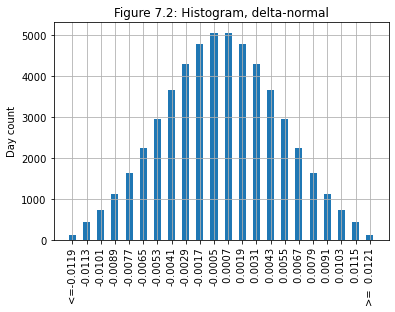

╒════════════════════╤════════════════╕
│ Statistic          │          Value │
╞════════════════════╪════════════════╡
│ Count              │ 12784          │
├────────────────────┼────────────────┤
│ Min                │    -0.0194116  │
├────────────────────┼────────────────┤
│ Max                │     0.0195616  │
├────────────────────┼────────────────┤
│ Mean               │     7.5e-05    │
├────────────────────┼────────────────┤
│ Median             │     7.5e-05    │
├────────────────────┼────────────────┤
│ Standard Deviation │     0.00515432 │
├────────────────────┼────────────────┤
│ Skewness           │     0          │
├────────────────────┼────────────────┤
│ Excess Kurtosis    │     0          │
├────────────────────┼────────────────┤
│ Jarque-Bera        │     0          │
├────────────────────┼────────────────┤
│ Chi-Squared p      │     1          │
├────────────────────┼────────────────┤
│ Serial Correlation │     0          │
├────────────────────┼────────────────┤


In [2]:
# get count
count=metrics[0]
#Transform logs to return space
x_returns=np.array(np.exp(difflgs)-1)
m_returns=np.mean(x_returns,axis=0)
c_returns=np.cov(x_returns.T)
# compute mean and std deviation directly from m and c
port_mean=np.dot(m_returns,w)
port_std=np.sqrt(np.matmul(np.matmul(w,c_returns),w))

#Redo histogram with normal assumption

bucketcounts=[]
bucketnames=[]
#Bucket the end percentiles
low1=port_mean+port_std*spst.norm.ppf(.01)
high1=port_mean+port_std*spst.norm.ppf(.99)
bucketwidth=(high1-low1)/nbucket
bucketcounts.append(spst.norm.cdf((low1-port_mean)/port_std)*count)
bucketnames.append('<=%7.4f' % low1)
for i in range(nbucket):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(spst.norm.pdf((mid-port_mean)/port_std)*count)

#last bucket
bucketcounts.append((1-spst.norm.cdf((high1-port_mean)/port_std))*count)
bucketnames.append('>=%8.4f' % high1)

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 7.2: Histogram, delta-normal')
plt.show();

#Delta-normal calculations - redo the stats table
table_norm=np.copy(table)
table_norm[1][1]=str(port_mean+spst.norm.ppf(1/(count+1))*port_std)    #min
table_norm[2][1]=str(port_mean+spst.norm.ppf(count/(count+1))*port_std)    #max
table_norm[3][1]='%7.7f' % port_mean    #mean - should be the same
table_norm[4][1]=table_norm[3][1]    #median - make it equal the mean because normal
table_norm[5][1]=str(port_std)    #standard deviation - use sqrt(w'Cw)
table_norm[6][1]="0"    #skewness - zero because normal
table_norm[7][1]="0"    #skewness - zero because normal
table_norm[8][1]="0"    #Jarque-Bera - zero because normal
table_norm[9][1]="1"    #Chi-squared - one because normal
table_norm[10][1]="0"    #Serial correlation - zero by assumption
p=.99
norm_VaR=-(port_mean+spst.norm.ppf(1-p)*port_std)
table_norm[11][1]=str(norm_VaR)    #99% VaR - from formula
norm_cVaR=port_std*np.exp(-.5*(norm_VaR/port_std)**2)
norm_cVaR/=(1-p)*np.sqrt(2*np.pi)
norm_cVaR=-port_mean+norm_cVaR
table_norm[12][1]=str(norm_cVaR)    #99% cVar - from formula
print(tabulate(table_norm, headers, tablefmt='fancy_grid'))

Figure 8.2 looks generally similar to Figure 8.1, but 8.2 falls off at the tails while 8.1 has extra probability at the two extremes as a result of its leptokurtosis.

Note that the standard deviations of the historical simulation and the delta-normal method agree to four decimal places. That's not a coincidence: if $X$ is the $T\times3$ matrix of daily returns of the three currencies, then the covariance matrix of returns is $C_{returns}=(X-JX/T)^{\intercal}(X-JX/T)/T$ where $J$ is the $T\times T$ matrix of all ones. The delta-normal calculation of standard deviation was $\sigma_{delta-normal}=\sqrt{w^{\intercal}C_{returns}w}$.

The historical simulation's standard deviation was obtained by forming the $T$-vector $r=(X-JX/T)^{\intercal}w$, and then taking componentwise logs, $r_{log}=log(1+r)$. The standard deviation of log-returns is $\sigma_{log-historical}=r_{log}^{\intercal}r_{log}/T$. Since daily returns are on the order of $10^{-4}$, $log(1+r)\approx r$ is a good approximation. So $\sigma_{delta-normal}\approx\sigma_{log-historical}$ to several decimal places.

While the delta-normal method doesn’t give a realistic picture of tail risk, it has a great advantage: the **`Euler Rule`**[$^2$](#eight_footnotes) can be applied. This decomposes overall standard deviation into its component parts.

It works like this: let $f(x)$ be a positive homogeneous and continuously differentiable scalar function of an $n$-vector $x=(x_1,\dots,x_n)$. Positive homogeneity of scalar degree $k$ means that $f(zx)=z^k f(x)$ for all real scalar $z>0$. If $f(x)$ is such a function, the Euler Rule states that
$$k\cdot f(x)=\sum_{i=1}^n x_i \frac{\partial f}{\partial{x_i}}(x)=x^{\intercal}(\nabla f(x))\label{eq:euler_rule}\tag{8.2}$$
$\nabla f(x)=(\frac{\partial f}{\partial{x_1}}(x),\dots,\frac{\partial f}{\partial{x_n}}(x))^{\intercal}$ is the gradient vector of $x$.

We know from the discussion of [coherent risk measures](#coherent_risk) that standard deviation $\sigma(w)=\sqrt{w^{\intercal} Cw}$ is positive homogenous with $k=1$. The gradient of standard deviation is $g=\nabla \sigma=\frac{1}{\sigma(w)}Cw$. Applying \eqref{eq:euler_rule} decomposes standard deviation into the influences of each component:
$$\sigma(w)=w^{\intercal}g\label{eq:euler_std}\tag{8.3}$$
The right-hand side of \eqref{eq:euler_std} is a vector dot product – the vector version of the Euler decomposition in \eqref{eq:euler_rule}. The $i^{th}$ summand ($i=1$ to $n$) in the dot product is $w_i g_i$, the contribution of the $i^{th}$ element to the overall delta-normal standard deviation.

Computing these quantities for the 3-currency example gives the following:

In [3]:
#Compute gradient
port_gradient=np.matmul(c_returns,w)/port_std
print('Gradient (bps/day):',port_gradient)
print('Contributions to Std Dev:',port_gradient*w)

Gradient (bps/day): [0.00616951 0.00457384 0.00471963]
Contributions to Std Dev: [0.0020565  0.00152461 0.00157321]


The Swissie is the biggest contributer to standard deviation. If an analyst expects one of the other currencies to outperform Swissies, some weight could be shifted from Swissies to that other currency, giving a win-win. Such a move would increase expected return while lowering expected risk. This works on the margin, but large changes in weights require a reassessment of overall risk.

This framework helps with risk/reward decisions. In more complex covariance matrices, there might be some items with a negative contribution $w_i g_i$ to overall standard deviation; those are diversifiers. If an analyst expects that a diversifier is going to generate more return than items with positive contributions, increasing the exposure to the diversifier will produce more expected return while reducing risk.

### 8.2.1 The Cornish-Fisher Expansion

One way of correcting the delta-Normal approach's underestimation of tail risk is to adjust statistics like Value at Risk with a **`Cornish-Fisher expansion`**. In the delta-Normal approach, VaR is simply $z\sigma$, where $\sigma$ is standard deviation and $z=Norm^{-1}(p)$; e.g. $z=2.326$ when $p=.99$. We saw, however that Historical Simulation VaR was higher than delta-Normal VaR, meaning the empirical $z$ multiple was bigger than the Gaussian $z$.

The Cornish-Fisher expansion (from a [1937 paper by E. A. Cornish & R. A. Fisher](https://doi.org/10.2307%2F1400905)) is essentially a Taylor series that takes into account moments of the distribution beyond the second moment to get a better estimate of the multiplier $z$. Taking into account the skewness and kurtosis terms gives
$$z_{new}=z-\frac{1}{6}(z^2-1)m_3+\frac{z}{24}(z^2-3)m_4-\frac{z}{36}(2z^2-6)m_3^2\label{eq:cornish_fisher}\tag{8.4}$$
Here $m_3$ is skewness and $m_4$ is (excess) kurtosis. For a normal distribution skewness and excess kurtosis are zero, so the Cornish-Fisher adjustment makes no change in that case.

[Maillard 2012](https://dx.doi.org/10.2139/ssrn.1997178) pointed out that the expansion only works in a certain range of skewness and kurtosis parameters. The absolute value of skewness must be outside a middle range, as shown:
$$6(\sqrt{2}-1)\geq|m_3|,\enspace6(\sqrt{2}+1)\leq|m_3|\label{eq:cornish_skewness}\tag{8.5}$$
So $|m_3|$ must be less than about $2.485$, or greater than about $14.485$. The top range &mdash; where skewness is greater than $14.485$ &mdash; is generally beyond repair by a simple adjustment. So the main applicability of Cornish-Fisher is in the lower range of skewness.

Kurtosis must be between the two roots of a quadratic:
$$4(1+11s^2-\sqrt{s^4-6s^2+1})\leq m_4\leq4(1+11s^2+\sqrt{s^4-6s^2+1})\label{eq:cornish_kurtosis}\tag{8.6}$$
where $s=m_3/6$. Thus when $s=0$, kurtosis must be between 0 and 8.

Figure 8.3 shows the valid parameter area for Cornish-Fisher in the lower range of skewness. Excess kurtosis is on the vertical axis; skewness is on the horizontal axis:

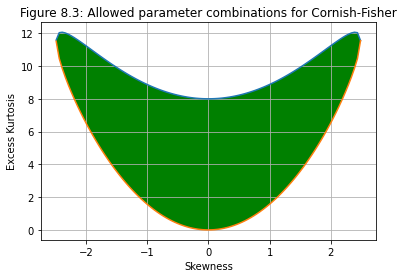

In [4]:
#Draw Cornish-Fisher admissability graph
stepsize=12*(np.sqrt(2)-1)/100
x=np.arange(-50*stepsize+.0001,
            50*stepsize,stepsize)
y1=[4*(1+11*(x/6)**2+np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
y2=[4*(1+11*(x/6)**2-np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
x=np.append(x,50*stepsize)
y1=np.append(y1,4*(1+11*(x[100]/6)**2))
y2=np.append(y2,4*(1+11*(x[100]/6)**2))
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2,facecolor='green')
plt.xlabel('Skewness')
plt.ylabel('Excess Kurtosis')
plt.title('Figure 8.3: Allowed parameter combinations for Cornish-Fisher')
plt.grid()
plt.show();

Applying \eqref{eq:cornish_fisher} to the Historical Simulation data above, we get the following:

In [5]:
#Compute new z-score using 8.4
z=spst.norm.ppf(p)
znew=z-(1/6)*(z**2-1)*spst.skew(portfolio)
znew+=(z/24)*(z**2-3)*spst.kurtosis(portfolio)
znew-=(z/36)*(2*z**2-5)*spst.skew(portfolio)**2
print_str='Normal %2.f pct' % np.multiply(p,100.)
print_str+=" z: %8.5f" % z
print(print_str)
print('Cornish-Fisher: %8.5f' % znew)
#Compare with historical
hs_99VaR=-np.percentile(portfolio,1)
zhist=(hs_99VaR+port_mean)/port_std
print('Historical: %8.5f' % zhist)

#Show comparisons of VaRs
print_str='\nNormal %2.f pct' % np.multiply(p,100.)
print_str+=" VaR: %8.5f" % norm_VaR
print(print_str)
cf_99VaR=-port_mean+znew*port_std
print('Cornish-Fisher VaR: %8.5f' % cf_99VaR)
print('Historical VaR: %8.5f' % hs_99VaR)

Normal 99 pct z:  2.32635
Cornish-Fisher:  3.27137
Historical:  2.58673

Normal 99 pct VaR:  0.01192
Cornish-Fisher VaR:  0.01679
Historical VaR:  0.01326


So in this case, the Cornish-Fisher expansion overcorrects, giving a more conservative Value at Risk than the one that arose from historical experience.

## 8.3 Monte Carlo Simulation

A third technique for generating distributions of portfolio outcomes is the **`Monte Carlo`** method. Monte Carlo is a reference to the [casinos in Monaco](https://www.montecarlosbm.com/en/casino-monaco), and indicates that a large number of random trials are generated to form a sample distribution. This idea was first conceived by Stanislaw Ulam in 1946 as a way of harnessing the nascent power of computers to find the probability of winning at solitaire. It was so named by Nicholas Metropolis based on the gambling habits of Ulam's uncle.[$^3$](#eight_footnotes)

To illustrate this, we'll start with a delta-normal model but then will add complexity.

Suppose then that we have an $n\times n$ covariance matrix $M$ and an exposure $n$-vector $e$ for a portfolio. We want to draw an $n$-vector of factor (or security returns) from the multivariate normal distribution with covariance matrix $M$.
To do this, we must **`Cholesky factor`** $M$:
$$M=LL^{\intercal}\text{  where }L\text{ is lower triangular}\label{eq:cholesky_factor}\tag{8.10}$$
If $M$ is positive semidefinite, then such a factorization is possible.

The algorithm for Cholesky factorization is straightforward. The lower triangular Cholesky factor of the 3-currency log-return covariance matrix \eqref{eq:three_currency_sampcov} is computed here:

In [6]:
#Show the Cholesky decomposition
#of the CHF-GPB-JPY covariance matrix
chol=np.linalg.cholesky(c)
print('(8.11) Cholesky decomposition of 3-currency sample'+ \
      ' covariance matrix:\n',chol*100)

(8.11) Cholesky decomposition of 3-currency sample covariance matrix:
 [[0.70595279 0.         0.        ]
 [0.34035761 0.4882504  0.        ]
 [0.30198568 0.02130788 0.55610753]]


<font color="white">$$\label{eq:cholesky_sampcov}\tag{8.11}$$</font>
To generate vectors drawn from a multivariate normal distribution with covariance $M$, the Monte Carlo process starts by generating n-vectors $s_j$ ($j=1$ to $T$, where $T$ the number of Monte Carlo trials desired) of independent draws from a standard (mean 0, standard deviation 1) normal distribution. Each $s_j$ consists of $n$ scalars each drawn independently from a standard normal distribution.

The vector $r_j=Ls_j$ is a draw from a multivariate normal with the desired covariance structure. This is because
$$\mathbb{E}[r_jr_j^{\intercal}]=\mathbb{E}[Ls_js_j^{\intercal}L^{\intercal}]=L\mathbb{E}[s_js_j^{\intercal}]L^{\intercal}=LL^{\intercal}=M\label{eq:cholesky_expectation}\tag{8.12}$$

We run $T$ trials (where $T$ is the number of days in the currency dataset), generating 3-vectors $s_1,\dots,s_T$. We form draws $r_i=Ls_i$. These return-vector draws are then dotted with the weight vector $w=(1/3, 1/3, 1/3)$ to generate $T$ rates of return.

In [79]:
#Generate random draws; use fixed seed to be replicable
from numpy.random import default_rng
rng = default_rng(12345678)

s_trial=rng.normal(0,1,size=[count,3])
logr_trial=np.matmul(chol,s_trial.T).T+m

#logr_trial has Monte Carlo log-returns; transform to returns
r_trial=np.exp(logr_trial)-1

#Get trial portfolio returns
r_ptrial=np.matmul(r_trial,w)
print("Monte Carlo with simple normal draws")
statnames,mettrial,tabtrial=qf.StatsTable(r_ptrial)
print(tabulate(tabtrial, headers, tablefmt='fancy_grid'))

Monte Carlo with simple normal draws
╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.0204272 │
├────────────────────┼───────────────┤
│ Max                │     0.0185333 │
├────────────────────┼───────────────┤
│ Mean               │    -4.3e-06   │
├────────────────────┼───────────────┤
│ Median             │     1.08e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0051776 │
├────────────────────┼───────────────┤
│ Skewness           │     0.0277483 │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │    -0.0306785 │
├────────────────────┼───────────────┤
│ Jarque-Bera        │     2.14188   │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0.342687  │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0068568 │
├────────────────────┼─────

In [86]:
s_2=np.cov(logr_trial.T)
print(s_2)

[[4.99477013e-05 2.43276672e-05 2.16555788e-05]
 [2.43276672e-05 3.59909409e-05 1.16017057e-05]
 [2.16555788e-05 1.16017057e-05 4.01669084e-05]]


These statistics are close to the statistics from the delta-normal method. There are some subtleties of the sampling distributions &mdash; even though we generated future outcomes by using draws from a normal distribution, there is some variation in what we will observe. For example, the skewness and kurtosis were not exactly zero in our sample, although they are zero in a true normal distribution. The standard deviation was slightly different.

The artificial future we generated using simple Monte Carlo looked a lot like the artificial future we generated using delta-normal, and the reasons for the differences are well understood. Sampling error is limited and can be made smaller simply by running more trials. We're not going to learn anything very interesting this way, except perhaps to get a feel of the impact of sampling error.

However there's no reason why the Monte Carlo process has to draw from a normal distribution. A wide variety of more realistic distributions could be used to give more realistic tail behavior. For example, the following code segment fits a mixture of normals to each currency separately. The mixture targets the currency's mean, standard deviation, and excess kurtosis along with zero skewness. Correlation structure is introduced by multiplying by the Cholesky factor of the correlation matrix.

The result of the Monte Carlo simulation in the next code block is much more realistic than the Monte Carlo with simple normal draws.

In [78]:
#Three-currency Monte Carlo with separate mixtures of normals
import random

def mixparams(d_in):
    #Find mixture-of-2-normals parameters w1, r, and sigma2 (7.21)
    sigma_mix=np.std(d_in)
    k_mix=spst.kurtosis(d_in)  #default is Fisher (normal=0)
    k=k_mix/3.+1
    w_1=min(.05,.9/k)   #Avoid negative denominator in r
    r=(k*(1-w_1)*w1+np.sqrt(w_1*(1.-w_1)*(k-1.)))/(w_1*(1-k*w_1))
    sigma_2=sigma_mix/np.sqrt(w_1*r+1.-w_1)
    return(w_1,r,sigma_2)
#Done with mixparams

rng = default_rng(33550336)   #6th perfect number
s_mix=[]
#Generate mix for each asset separately
for asset in range(len(d.T)):
    w1,r,s2=mixparams(d[:,asset])
    count_1=int(count*w1)
    count_2=count-count_1
    s_1=rng.normal(0,np.sqrt(r)*s2,size=count_1)
    s_2=rng.normal(0,s2,size=count_2)
    s_mix.append(random.sample(list(np.append(s_1,s_2)),k=count))

#Cholesky factor of correlation matrix
corr_chol = np.linalg.inv(np.diag(np.sqrt(np.diagonal(c)))) @ chol
    
#introduce covariance structure and translate
logr_mix=(corr_chol @ s_mix).T+m

#logr_mix has Monte Carlo log-returns; transform to returns
ret_mix=np.exp(logr_mix)-1

#Get trial portfolio returns
ret_pmix=np.matmul(ret_mix,w)
print("Monte Carlo with leptokurtic mixtures of normals")
statnames,mettrial,tabtrial=qf.StatsTable(ret_pmix)
print(tabulate(tabtrial, headers, tablefmt='fancy_grid'))

Monte Carlo with leptokurtic mixtures of normals
╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.0498985 │
├────────────────────┼───────────────┤
│ Max                │     0.0421068 │
├────────────────────┼───────────────┤
│ Mean               │     7.12e-05  │
├────────────────────┼───────────────┤
│ Median             │     8.11e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.005456  │
├────────────────────┼───────────────┤
│ Skewness           │    -0.188056  │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     8.13627   │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 35337.3       │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │    -0.0164921 │
├──────────────

The true power of the Monte Carlo approach comes in applying a full valuation to every instrument in the portfolio. For example, suppose a portfolio contains derivatives or other complex instruments. Monte Carlo-ing &mdash; even when imitating realistic leptokurtic behavior &mdash; will not help if the pricing functions are simply based on delta (i.e., linear). The portfolio manager needs to know when derivatives might provide protection and when they might blow up. Using the full valuation formula, not an approximation, provides this information.

In full generality &mdash; as described at the beginning of this chapter &mdash; a $k$-vector $\text{sv}$ of state variables describes the relevant financial and economic state of the world, or at least the parts of the world that are relevant to the portfolio under analysis. A full Monte Carlo approach first generates $T$ draws of the state variable vector $\text{sv}$ from an appropriate distribution, which may be empirical, normal, Student's T, a mixture of normals, stable, or others.

A series of transformations and back-transformations might be applied to the state variables. For example, suppose we think there is significant serial correlation so that $\text{sv}_{i,t}=a_i\text{sv}_{i,t-1}+\epsilon_{i,t}$, where $\epsilon_{i,t}$ is a draw from a normal distribution that is independent of any previous $\epsilon_{i,s}$, $s<t$. In that case we would form the time series $\text{sv}_{i,t}-a_i\text{sv}_{i,t-1}=\epsilon_{i,t}$ and estimate $\epsilon_{i,t}$'s volatility and relationships with other transformed state variables. We would then Cholesky factor the state variable covariance matrix as in \eqref{eq:cholesky_factor}, and draw $T$ values of $\epsilon_{i,t+1}$ from a multivariate normal distribution that included the other transformed state variables. Of course other multivariate distributions could be used, and relationships could be captured by a copula function rather than a covariance matrix as described in Chapter 10 below.

When a vector of transformed state variables has been produced, a back-transformation (in the example, $\text{sv}_{i,t+1}=a_i\text{sv}_{i,t}+\epsilon_{i,t+1}$) is applied to get the right inputs for the pricing functions $R_i(\text{sv})$ $(i=1,\dots,n)$ shown in Table 8.1.

As noted above, these pricing functions give the rates of return of each instrument given the state variable changes in $\text{sv}$. The pricing functions may have nonlinear or other complex aspects. They may even use their own Monte Carlo simulations based on variables that are different from the portfolio-wide state variables in $\text{sv}$.

The final step in Monte Carlo simulation is aggregation of individual prices (or rates of return) to an overall portfolio price, rate of return, or other statistic such as a log-return. The resulting distribution of portfolio prices, returns, or log-returns can be used to judge risk and reward. Sample statistics like mean, standard deviation, and expected shortfall can be computed, or we can just map the distribution and see if it has an acceptable shape.

### 8.3.1 Delta-Gamma, Delta-Gamma-Theta Simulations

The detailed Monte Carlo process we just described can be difficult to implement fully. Even when the resources are available to gather all the requisite data and to code all the requisite algorithms, the time required to run all the simulations can be prohibitive. An institution requiring daily risk assessments may have difficulty completing all the calculations between the close of yesterday's markets and the open of today's markets, and an institution requiring continuously updated risk assessment may find the task hopeless.

We've seen that delta-normal simulations, which are usually computationally tractable, can oversimplify. We've noted that detailed Monte Carlo simulations can take too many resources and too much time. Compromises between these extremes use more terms of a Taylor series in an attempt to tune the tradeoff between speed and power.

A **`delta-gamma`** simulation includes both first and second-order terms in the pricing functions. For a multivariate simulation, that means that a **`Hessian matrix`** of mixed partial derivatives must be estimated for every instrument. The $(i,j)$ entry of the Hessian $\Gamma_i$ is $\frac{\partial R_i}{\partial \text{sv}_i\partial \text{sv}_j}$, where $R_i$ is the $i^{th}$ pricing function and $\text{sv}$ is the vector of state variables as in Table 8.1.

The rate of change with respect to time is often included along with the first and second order dependencies on the state variables. Let $\theta_i=\frac{\partial R_i}{\partial t}$ be the rate of change of the $i^{th}$ instrument's pricing function with respect to time. If the $i^{th}$ instrument is cash, for example, then $\theta_i$ is the risk-free rate.

The addition of time dependence to a delta-gamma approximation makes it a **`delta-gamma-theta`** approximation. The approximate pricing delta-gamma-theta pricing function is
$$\tilde{R_i}(\Delta\text{sv})=\Delta\text{sv}^{\intercal}\Gamma_i\Delta\text{sv}+\delta_i^{\intercal}\Delta\text{sv}+\theta_i\Delta t\label{eq:delta_gamma_theta}\tag{8.21}$$
Here we have made the pricing function explicitly dependent on changes rather than on levels; $\Delta t$ is the length of time in a simulation step. Of course without the last term on the RHS, \eqref{eq:delta_gamma_theta} is just a delta-gamma approximation.

The goal of replacing full valuation functions $R_i$ with approximations $\tilde{R_i}$ is, as noted above, to save simulation time and complexity. However, each Hessian matrix $\Gamma_i$ requires $f^2$ parameters, where $f$ is the number of state variables. Reliable estimation of this many parameters can be unrealistic, so lower-dimensional models can be used. In some cases, the off-diagonal elements of the Hessian matrix are assumed to be zero and only the diagonal elements are estimated.

## 8.4 Markov Chain Monte Carlo ##

The **`Markov Chain Monte Carlo (MCMC)`** method, like the other Monte Carlo methods explored in this chapter, uses random sampling from a distribution to explore a sample space. But unlike simple Monte Carlo methods, MCMC guides itself through the sample space in a way that is intended to enrich the predictive validity of the sample.

As we noted in Section 3.7, a [Markov Chain](#markov_process) only depends on the previous state. So the first "MC" in "MCMC" means that sampling can be done sequentially through an algorithm that only needs to remember the previous iteration. A Markov Chain on a finite sample space with $n$ states $[1,\dots,n]$ can be embodied in a transition matrix $T$ (similar to the ones used in Ross Recovery in Section 2.9) where the $(i,j)$ entry is the probability of moving from state $i$ to state $j$. In that case $T$ is row-stochastic (its row sums equal one), because when leaving state $i$ the next state has to be in the sample space.

In the continuous case, there is a transition probability density function $Tr(y\mid x)$ that gives the probability of moving from state $x$ to state $y$. For example a normal transition function $Tr_{norm}(y\mid x)=\frac{1}{\sqrt{2\pi}\sigma}exp\bigl(\frac{-(y-x)^2}{2\sigma^2}\bigr)$ for some standard deviation parameter $\sigma$.

Under reasonable conditions a unique **`stationary distribution`** $\pi(x)$ of a Markov Chain can be computed: $\pi(x)$ is the long-run probability that the chain is in state $x$, i.e. the probability that an infinte-length chain with transition probability $Tr$ is in state $x$. If the state space is finite, taking the dot product of the $i^{th}$ column of the transition matrix $T$ with the stationary probability vector $\pi$ gives $\pi_i$. This happens because we can enumerate all the states $j$ that could have transitioned into state $i$: the probability of being in state $j$ over the long run is $\pi_j$ and the probability of transitioning from $j$ to $i$ is the $(j,i)$ entry of $T$. So running through all $n$ states that could have transitioned to $i$ gives the aforementioned dot product, which must result in the probability of being in state $i$ which is $\pi_i$.

As a matrix equation, $T^{\intercal}\pi=\pi$. That is, the stationary distribution vector $\pi$ is a left eigenvector of the transition matrix $T$ with eigenvalue $1$. For the continuous case, $\pi(y)=\int \pi(x)Tr(y \mid x)dx$.

The **`Metropolis-Hastings Algorithm`**[$^4$](#eight_footnotes) takes advantage of the Markov Chain properties noted above to randomly sample a chain of values $x_0,x_1,\dots,x_n$ that are drawn from the stationary distribution, even if that distribution is not directly known. The algorithm assumes $Tr(x\mid y)$ is known. We'll assume a strong property that describes the relationship between the stationary distribution and the transition probability:
$$\frac{\pi(x)}{\pi(y)}=\frac{Tr(x \mid y)}{Tr(y\mid x)}\label{eq:mhast_balance}\tag{8.30}$$

Some of the initial values (called **`burn-in`**) in the chain $x_0,x_1,\dots,x_n$ may be discarded as the algorithm finds the proper range; often the first $20\%$ of the $n$ values are treated as burn-in. At each step of the algorithm, a random sample is taken from a **`proposal distribution`** $p(s\mid x_t)$; often the proposal distribution is a normal $N(x_t,\sigma)$ where $\sigma$ is an algorithm parameter that represents a tradeoff between speed and accuracy. More generally the proposal distribution may be asymmetric.

Here's the Metropolis-Hastings algorithm:
1. Pick a starting value $x_0$. Set $t=0$.
2. Generate a random sample $s_t$ from the proposal distribution $p(s\mid x_t)$.
3. Compute an acceptance ratio
$$r(s_t,x_t)=\frac{Tr(s_t\mid x_t)}{Tr(x_t\mid s_t)}\frac{p(x_t\mid s_t)}{p(s_t\mid x_t)}\label{eq:acceptance_ratio}\tag{8.31}$$
4. Generate a random sample $u_t$ from the uniform distribution over $[0,1]$. If $r(s_t,x_t)\geq u_t$, set $x_{t+1}=s_t$. Otherwise set $x_{t+1}=x_t$.
5. Increment $t$ and go back to Step 2 unless stopping. Stopping may occur after a predetermined number of steps, or when it appears that the sample distribution is not changing much.

Because of the assumption \eqref{eq:mhast_balance}, the acceptance ratio \eqref{eq:acceptance_ratio} is the same as $\frac{\pi(s_t)}{\pi(x_t)}\frac{p(x_t\mid s_t)}{p(s_t\mid x_t)}$; this produces the desired sample distribution from the algorithm.

We'll show a toy example of Metropolis-Hastings based on a symmetric $3\times 3$ transition matrix
$$T=
  \left[ {\begin{array}{ccc}
   .6 & .3 & .1\\
   .3 & .5 & .2\\
   .1 & .2 & .7\\
  \end{array} } \right]
$$

For a symmetric stochastic matrix $T$, $Tu=u$ where $u$ is the vector of all ones, so the stationary distribution is uniform.

We'll use a tent proposal distribution, i.e. $p(i\mid i)=\frac{2}{3}$ and $p(i\mid \neq i)=\frac{1}{6}$ where $i$ is one of the three states. The code runs the algorithm and compares the sample frequencies of being in each of the three states with the uniform distribution:

In [11]:
#MCMC on 3x3 state transition matrix
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng(138064852)  #Boltzmann

def tent(i,j):
    #Tent proposal distribution
    if j==i:
        return(2./3.)
    else:
        return(1./6.)

def transition(i,j):
    #Transition probability 
    T=[[.6,.3,.1],[.3,.5,.2],[.1,.2,.7]]
    if i<0 or i>2 or j<0 or j>2 or (not isinstance(i,int)) or (not isinstance(j,int)):
        return(0)
    return(T[i][j])

def picktent(x):
    #Pick a random state given previous state is x
    movers=[0,0,0,0,1,2]
    choose=rng.integers(0,6)
    pick=int(x+movers[choose])
    return(pick % 3)

n=1000  #Arbitrary
burnin=int(.2*n)

#Step 1
x=[0 for i in range(n)]
x[0]=1   #Start in middle state

for t in range(n-1):
    #Step 2
    s_t=picktent(x[t])
    #Step 3
    trans_ratio=transition(s_t,x[t])/transition(x[t],s_t)
    prop_ratio=tent(x[t],s_t)/tent(s_t,x[t])
    accept_ratio=trans_ratio*prop_ratio
    #Step 4
    u_t=rng.uniform()
    if accept_ratio >= u_t:
        x[t+1]=s_t
    else:
        x[t+1]=x[t]
        
for state in range(3):
    this_pct=sum([1 for samp in x[burnin:] if samp==state])/(n-burnin)
    print_str="    State: %d" % state
    print_str+=" MCMC: %5.3f" % this_pct
    print_str+=" Theoretical: %5.3f" % float(1./3.)
    print(print_str)


    State: 0 MCMC: 0.315 Theoretical: 0.333
    State: 1 MCMC: 0.321 Theoretical: 0.333
    State: 2 MCMC: 0.364 Theoretical: 0.333


Metropolis-Hastings can be used to generate samples when there are transition matrices or transition probability distributions.

Another MCMC method used in finance is a **`Gibbs Sampler`**,[$^5$](#eight_footnotes) which among other things is useful for implying missing data. The Gibbs Sampler is a bootstrap process that constructs samples from an unknown joint distribution when only conditional distributions are known.

More specifically, suppose there is an unknown joint density function $f(x,y)$ of two variables (which could each be a vector). While $f(x,y)$ is not known, the conditional density $f(x\mid y)=\frac{f(x,y)}{f_Y(y)}$ is known. Here $f_Y(y)$ is the marginal density for the second variable, i.e. $f_Y(y)=\int f(x,y)dx$ where the (possibly multiple) integral is over the domain of $x$. Similarly assume $f(y\mid x)$ is known.

The Gibbs Sampler works like this:
1. Pick a starting value for the $x$ variable, $x_1$. Set $t=1$.
2. Generate a random sample $y_t$ of the $y$ variable from the conditional distribution $f(y\mid x_t)$.
3. Generate a random sample $x_{t+1}$ from the conditional distribution $f(x\mid y_t)$.
4. Increment $t$ and go back to Step 2 unless stopping.

The stopping rule can be a fixed number of iterations, or a method that looks for stable statistical properties.

To illustrate this method, we'll modify an application from O'Cinneade.[$^5$](#eight_footnotes) Suppose $D_m$ is an $n_m\times T_m$ data matrix containing monthly log-returns of $n_m$ market assets, and $D_e$ is an $n_e\times T_e$ data matrix containing quarterly economic data over the same time span. We'll work an example that uses the ten years ending at the end of the most recent year, so $T_m=120$ months for the monthly data and $T_e=40$ quarters for the quarterly data.

Market data often anticipates economic data. For example, the US stock market dropped about $20\%$ in first quarter of 2020 due to COVID-19 pandemic fears. But the US GDP was roughly unchanged in first quarter 2020. US GDP was down about $10\%$ in _second_ quarter 2020 while the stock market recovered. Thus we'll put a one quarter lag in the market data.

With the lag, the first three months of market data in $D_m$ will be from October/November/December, while the corresponding first quarter of economic data in $D_e$ will be from the first quarter of the next year. The last three months of market data in $D_m$ will be from July/August/September, while the corresponding last quarter of economic data in $D_e$ will be from the fourth quarter. This means there will be a predictive component to this application: the most recent market data will anticipate not-yet-seen economic data. We'll expand on this below.

We'd like to understand the relationships between market data and economic data. The most obvious thing to do is to dumb down the monthly market data by combining the months into quarters, and then looking at the relationships in the quarterly data. However this seems wasteful: it coarsens the precision of the monthly data.

A different approach is to smarten up the quarterly data: use the existing information to guess what the missing monthly returns of the quarterly data should look like. The resulting pseudo-monthly economic series can then be compared to other monthly series. We will
1. Infer relationships between $n_m$ monthly series and $n_e$ quarterly series by coarsening the monthly series to quarterly and seeing how the quarterly series relate; and
2. Use those relationships (via a Gibbs Sampler) to generate likely values for the missing monthly data points of the quarterly series.

We can then use the pseudo-monthly economic series along with other monthly data in simulations and other historical studies.

We first estimate the following quantities from the data $D_m$ and $D_e$. $u_s$ is the $s\times 1$ vector of all ones.
- $\mu_m=\frac{1}{T_m}D_m u_{T_m}$, the $n_m$-vector of monthly mean log-returns of the market series estimated from all $T_m$ monthly market log-returns;
- $C_m=\frac{1}{T_m}(D_m-\mu_m u_{T_m})(D_m-\mu_m u_{T_m})^{\intercal}$, the $n_m\times n_m$ covariance matrix of the market data;
- $\mu_e=\frac{1}{3T_e}D_e u_{T_e}$, the $n_e$-vector of month-ized quarterly mean returns of the $n_e$ economic series estimated from all $T_e$ quarterly economic returns;
- $C_e=\frac{1}{3T_e}(D_e-\mu_e u_{T_e})(D_e-\mu_e u_{T_e})^{\intercal}$, the $n_e\times n_e$ month-ized covariance matrix of the economic data;
- $C_{me}=\frac{1}{3T_e}(D_m-\mu_m u_{T_m}^{\intercal})\text{MQ}(D_e-3\mu_e u_{T_e})^{\intercal}$, the $n_m\times n_e$ month-ized matrix of covariances between quarterly market data and quarterly economic data. $\text{MQ}$ is a $T_m\times T_e$ matrix with three consecutive ones in each column and zeros elsewhere. The ones start in row $3(j-1)+1$ of the $j^{th}$ column.

From these quantities we an compute the conditional mean $\mu_{e\mid m}(t)$ and the conditional covariance matrix $C_{e\mid m}$ of the missing monthly observations of the quarterly data in month $t$. Actually the conditional mean is dependent on the month but the conditional covariance matrix isn't:[$^6$](#eight_footnotes)

$$\mu_{e\mid m}(t)=\mu_e + C_{me}C_m^{-1}(D_m(t)-\mu_m)\label{eq:gibbs_condl_mean}\tag{8.35}$$
$$C_{e\mid m}=C_e - C_{me}^{\intercal}C_m^{-1}C_{me}\label{eq:gibbs_condl_cov}\tag{8.36}$$

Here $D_m(t)$ is the $t^{th}$ column of the data matrix, i.e. the log-returns of the monthly data in month $t$.

With these quantitites defined, we can apply Gibbs sampling by letting
- $x_t=\mu_{e\mid m}(t)$ be the conditional mean of the missing monthly economic data in month $t$; and
- $y_t$ be the $n_e$-vector of missing monthly economic series returns in month $t$.

Following O'Cinneade,[$^5$](#eight_footnotes) the steps of the Gibbs Sampler in this case look like
1. Let $x_1$ be $\mu_e$. Set t=1.
2. Randomly sample an $n_e$-vector from $N(x_t,C_{e\mid m})$. Call this sample vector $z_t$.
3. (a) If $t$ is not a quarter-end month, go to step 4.
<br>
(b) If $t$ is a quarter-end month, let $Z_t=z_t+z_{t-1}+z_{t-2}$ be the most recent quarterly log-return vector produced by this process. Let $D_e(t/3)$ be the column of $D_e$ containing the actual quarterly log-return for this quarter. Set $y_{t-j}=z_{t-j}+(D_e(t/3)-Z_t)/3$ for $j=0,1,2$.
4. Increment $t$. Stop when $t>T_m$. Otherwise set $x_t=\mu_{e\mid m}(t)$ as defined in \eqref{eq:gibbs_condl_mean}.

Step 3b ensures that the quarterly log-returns of filled-in monthly series $y_t$ match the original data. Step 2 in this algorithm looks like step 2 in the generic Gibbs Sampler, but step 3 here doesn't actually generate a random sample from $f(x\mid y_t)$ as in the generic case.

The code in the next cell implements this algorithm using stock market indices for the US, Europe and Japan as the market data, and Gross Domestic Product information as the economic data. Both are converted to log-changes (log-returns). The market data is aligned so that it is three months earlier than the economic data, i.e. the first quarter market returns are aligned with the second quarter GDP data. The three graphs show the original GDP levels and the pseudo-monthly GDP levels that are computed from the output of the Gibbs Sampler.

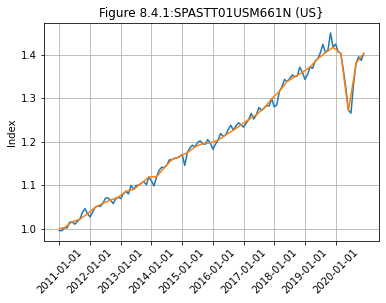

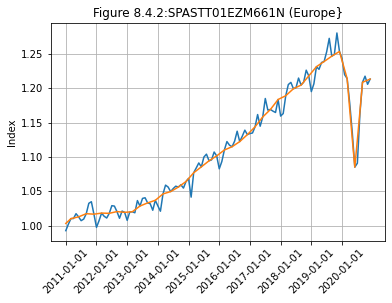

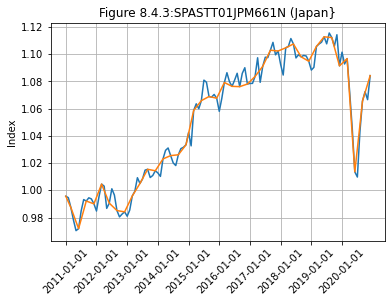

In [12]:
#MCMC Gibbs Sampling to fill in missing data

need_data=True    #Indicator to make sure we got previous year's data
lastday=qf.LastYearEnd()

while need_data:    #Get most recent year available
    firstday_e=str(int(lastday[:4])-10)+'-10-01'  #Go back 10 years (quarterly)
    #Quarterly economic data US, Euro, Japan
    seriesnames=['GDP','EUNNGDP','JPNNGDP']
    cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=firstday_e,enddate=lastday)
    if not any(np.isnan(ratematrix[-1])):        #See if we got desired data
        need_data=False
    else:    #go back a year
        lastday=str(int(lastday[:4])-1)+lastday[-6:]    
    
#Get log-changes of GDP data
lgdates_e,difflgs_e=qf.levels_to_log_returns(cdates,ratematrix,[1,1,1])

#Monthly stock market data US, Euro, Japan
firstday_m=str(int(lastday[:4])-10)+'-09-01'  #Go back 10 years with quarter offset
seriesnames=['SPASTT01USM661N','SPASTT01EZM661N','SPASTT01JPM661N',]
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=firstday_m,enddate=lastday)
lgdates_m,difflgs_m=qf.levels_to_log_returns(cdates,ratematrix,[1,1,1])

#Compute parameters explained in text
n_m=len(difflgs_m[0])                         #Number of monthly series
n_e=len(difflgs_e[0])                         #Number of quarterly series
T_m=len(difflgs_m)-3                          #Number of months in monthly series
T_e=len(difflgs_e)                            #Number of quarters in quarterly series
D_m=np.array(difflgs_m[:-3])                  #Monthly data (n_m x T_m) (offset by a quarter)
D_e=np.array(difflgs_e)                       #Quarterly data (n_e x T_e)
mu_m=np.mean(D_m,axis=0)                      #Mean vector of monthly data
C_m=np.cov(D_m.T)                             #Covariance matrix of monthly data
mu_e=np.mean(D_e,axis=0)/3.                   #Month-ized mean vector of quarterly data
C_e=np.cov(D_e.T)/3.                          #Month-ized covariance matrix of quarterly data

#Monthly data quarter-ized and de-meaned
QD_m=[D_m[t]+D_m[t+1]+D_m[t+2]-3.*mu_m for t in range(0,T_m,3)]

#Market/economic covariance matrix
C_me=(list(zip(*QD_m)) @ (D_e-np.tile(3.*mu_e,(T_e,1))))/(3.*T_e)

#Conditional distribution covariance matrix
C_e_bar_m=C_e-((C_me.T @ np.linalg.inv(C_m)) @ C_me)

#Set up for Gibbs sampler
y=np.zeros((T_m,n_e))   #Output: pseudo-monthly economic series
z=np.zeros((T_m,n_e))   #pre-adjusted pseudo-monthly economic series

#Step 1
x_t=mu_e
t=1
done=False
while not done:
    #Step 2 (python indexing convention off one from text)
    z[t-1]=rng.multivariate_normal(x_t,C_e_bar_m)
    #Step 3
    if t % 3 == 0: # This is a quarter-end
        adjust = (D_e[int(t/3)-1]-(z[t-1]+z[t-2]+z[t-3]))/3.
        for q in range(1,4):
            y[t-q]=z[t-q]+adjust
    #Step 4
    x_t=mu_e+((C_me.T @ np.linalg.inv(C_m)) @ (D_m[t-1]-mu_m))
    t+=1
    done = (t > T_m)

#Plot quarterly economic series vs. monthly as index values
names=['US','Europe','Japan']
for e in range(n_e):
    yy=np.exp(np.cumsum(y[:,e]))
    dd=[[D_e[i][e]/3]*3 for i in range(T_e)]   #straight-line interpolate quarterly to monthly
    DD=np.exp(np.cumsum(dd))
    plt.plot(range(T_m),yy)
    plt.plot(range(T_m),DD)
    plt.ylabel('Index')
    plt.xticks(range(0,T_m,12),lgdates_m[3:][::12],rotation=45)
    str_title='Figure 8.4.%d:' % (e+1)
    str_title+=seriesnames[e]+' ('+names[e]+'}'
    plt.title(str_title)
    plt.grid()
    plt.show();

The more jagged blue lines are the pseudo-monthly GDP series. Each quarter the blue line coincides with the orange line: the orange line is the original quarterly GDP data.

The pseudo-monthly series can be mixed with other monthly data for historical studies. There is also a prediction at the tail end of the data: the market data in $D_m$ ended in September, while the GDP data ended in December. We didn't use the fourth quarter market data, which aligns with first quarter economic data. The prediction is simply that first quarter economic data will be drawn from $N(x_t,C_{e\mid m})$. The next code segment displays these numbers:

In [13]:
#Sum last 3 conditional means
x_t=0
for t in range(-1,-4,-1):
    x_t+=mu_e+((C_me.T @ np.linalg.inv(C_m)) @ (difflgs_m[-t]-mu_m))

print(f'Final quarterly mean vector for GDP log-changes, quarter ending {lastday}')
for e in range(n_e):
    print('{:9}: {:8.5}'.format(names[e],x_t[e]))

#Display conditional covariance matrix
print('\nConditional covariance matrix:')
for e in range(n_e):
    print('{:9.6} {:9.6} {:9.6}'.format(C_e_bar_m[e][0],C_e_bar_m[e][1],C_e_bar_m[e][2]))
    
#See if subsequent 1Q GDPs available    
newday=str(int(lastday[:4])+1)+'-01-01'
seriesnames=['GDP','EUNNGDP','JPNNGDP']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=lastday,enddate=newday)

#Show actual log-changes if available
print(f'\nActual log-changes of GDPs, first quarter {newday[:4]}')
for e in range(n_e):
    if not(np.isnan(ratematrix[-1][e])):
        lrt=np.log(ratematrix[-1][e]/ratematrix[0][e])
        print('{:9}: {:8.5}'.format(names[e],lrt))
    else:
        print('{:9}: Not available'.format(names[e]))

Final quarterly mean vector for GDP log-changes, quarter ending 2020-12-31
US       : 0.023255
Europe   : 0.022424
Japan    : 0.012857

Conditional covariance matrix:
8.52664e-05 0.000101318 5.90008e-05
0.000101318 0.000138857 7.27364e-05
5.90008e-05 7.27364e-05 7.01479e-05

Actual log-changes of GDPs, first quarter 2021
US       : 0.025768
Europe   : 0.0043372
Japan    : -0.0075239


There is nothing new about the prediction contained in $\mu_{e\mid m}$: it's just a lagged regression. Market participants are able to react quickly to news like the onset of a pandemic, while large economies are like massive container ships at sea: it takes a long time for them to turn around. So it isn't surprising when market data precedes economic data, and $\mu_{e\mid m}$ is sometimes close to the actual subsequent GDP change. At other times, $\mu_{e\mid m}$ is so far off that Paul Samuelson's quip about the market predicting nine of the last five recessions comes to mind.

While the predictive component of this process has varying results, the real contribution of this application of MCMC is the ability to fill in missing data in a Bayesian framework. As we noted above, this makes the resulting pseudo-monthly series useful in simulations and other historical studies.

## 8.5 Stress Testing and Scenario Analysis

We have noted that financial markets are subject to Knightian Uncertainty. Efforts to generate a realistic returns distribution for a portfolio assume counterfactually that we are in a world of Knightian Risk, i.e. that we can know all the outcomes and all their associated probabilities. 

While we clearly aren't always in a world of Knightian Risk, much of the time we are, especially in developed financial markets. For example if we discard the leftmost and rightmost bars of the histogram in Figure 8.1, the remaining observations of an equal-weighted portfolio of currencies do look remarkably normal. But the tail events destroy any hope of normality.

We would still have work to do even if we reacquired a state of Knightian Risk at the portfolio level. Suppose that we find a fat-tailed cdf $F(x)$ that is the true generating distribution for portfolio log-returns, so that $F(x)$ describes (to within negligible sampling error) the probability that future empirical log-returns at the portfolio level will be less than or equal to $x$.

Knowing $F(x)$ would be helpful, but we still wouldn't know which combination of state variables led to which outcome. Maybe the lower part of the distribution is caused by a cluster of state variables associated with hyperinflation, or maybe it's caused by a cluster of state variables associated with deflation. Or maybe some of the lower tail is caused by each of these, i.e. by completely opposite effects. The cdf F(x), even if it's spot on, might say "how much" but it doesn't say "why."

But if we're going to prepare our portfolios for the future, we need to have an idea of why they might get into the tails. Because there is typically not enough data to estimate "why" &mdash; i.e. which highly unusual combination of state variables might be the one that will lead to the next tail event &mdash; we need to use a more intuitive approach.

**`Stress testing`** takes one, or a small number, of key factors in our state variable vector $\text{sv}$ and **`shocks`** it (them) by a very large move. For example, interest rates generally move by 10 or fewer basis points a day. An interest rate stress test might move rates up or down by 200 basis points. Suppose that the US Treasury 10-year rate is the factor in $\text{sv}$ representing interest rates; then we would form $\text{sv}_{\pm}=\text{sv}\pm\delta_{UST10YR}.02$, where $\delta_{UST10YR}$ is a $k$-vector of zeroes except for a one in the US Treasury 10-year element. We would then reprice the portfolio $\text{Port}(R_1(\text{sv}_{+}),\dots,R_n(\text{sv}_{+}))$ (and similarly for $\text{Port}(R_1(\text{sv}_{-}),\dots,R_n(\text{sv}_{-}))$ to get an idea of the portfolio's response to extreme changes in interest rates.

**`Scenario analysis`** envisions a full economic situation affecting many if not all of the factors. **`Historical`** scenario analysis attempts to reproduce the changes in factors during unusual historical periods, such as the Great Depression starting in 1929, or the technology bust of 2000, or the global financial crisis of 2008-2009.

**`Hypothetical`** scenario analysis envisions a possible future stressful scenario, such as hyperinflation following a policy error by central banks. Hypothetical scenario analysis starts with a qualitative narrative, but must finish with a $k$-vector $\text{sv}_{hypothetical}$ that specifies levels or changes in the state variables so that $\text{Port}(R_1(\text{sv}_{hypothetical}),\dots,R_n(\text{sv}_{hypothetical}))$ can be formed.

This can be difficult: for example in a US dollar hyperinflation scenario, analysts might focus carefully on financial variables in the US. But what would happen to the USD/JPY (Japanese yen) exchange rate? Maybe the yen would have even worse hyperinflation, or maybe it would be a haven of stability.

If analysts don't have the expertise to form opinions on certain state variables like the Japanese yen, they might seek to fill in the missing variables. Suppose $\text{sv}_0$ is the vector containing changes in the variables where expert opinions are available and $\text{sv}_1$ is the vector containing the unknown variables. Then either historical information or a model could be used to obtain conditional distributions $f(\text{sv}_0\mid \text{sv}_1)$ and $f(\text{sv}_1\mid \text{sv}_0)$, which would allow a Gibbs sampler to be run to fill in the agnostic variables as shown in the previous section.

Both historical and hypothetical scenario analysis require as much art as science. As Mark Twain is supposed to have said, "History never repeats itself. But it does rhyme." There may be another global pandemic in the year $2050$, but it will certainly not be precisely like the COVID-19 pandemic starting in the year $2020$. Still, subjecting a portfolio in the year $2050$ to the pandemic state variable changes from $2020$ might rhyme &mdash; maybe the 30-year-old financial variable changes will be helpful in alerting human analysts to possibilities. But there are an infinite number of possible extremely unusual versions of the future: human judgment needs to be used to determine which ones deserve our attention.

## Chapter 8 Footnotes
<a name="eight_footnotes"></a>
<br>
$^1$ As we've previously noted, it's more likely that log-returns follow a multivariate normal distribution than simple returns. To compute portfolio log-returns, security log-returns need to be converted to simple returns, combined, and then converted back to log-returns: that's what was done in the historical simulation. In the delta-normal illustration, we've just modeled returns themselves as normal for simplicity.
<br>

$^2$ More precisely, this is Euler's Homogenous Function Theorem. It follows directly from the definition of homogeneity $f(zx)=z^k f(x)$ by differentiating both sides with respect to $z$, applying the chain rule, and setting $z=1$.
<br>

$^3$ Metropolis, Nicholas, _The Beginning of the Monte Carlo Method_, Los Alamos Science, Special Issue 1987. http://library.lanl.gov/cgi-bin/getfile?15-12.pdf
<br>

$^4$ Metropolis et. al. described the symmetric case, while Hastings added asymmetry. Metropolis, Rosenbluth, Rosenbluth, and Teller, "Equation of State Calculations by Fast Computing Machines," J. Chem. Phys. 21, 1087 (1953) https://doi.org/10.1063/1.1699114. Hastings, "Monte Carlo Sampling Methods Using Markov Chains and Their Applications". Biometrika. 57 (1): 97–109 https://doi.org/10.1093%2Fbiomet%2F57.1.97
<br>

$^5$ O'Cinneade, Colm. "Bayesian Methods in Investing," in _The Oxford Handbook of Quantitative Asset Management_, (Scherer and Winston, eds.). Oxford University Press, 2012. pp. 87-115.
<br>

$^6$ See O'Cinneade, op. cit., p. 105. There is an error in O'Cinneade's formula at the bottom of p. 105. In his notation, $\Sigma_{J\mid I}$ in the formula for $\mu_{tJ\mid I}$ should actually be $\Sigma_{JI}$.